<a href="https://colab.research.google.com/github/Dina-Nabil/Image-Mosaics/blob/master/Image_Mosaics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload Images

In [0]:
from google.colab import files
uploaded = files.upload()

Saving imagea.png to imagea.png
Saving imageb.png to imageb.png


In [0]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import random

In [0]:
def plot_image(image,color,title):
  plt.grid("false")
  plt.title(title)
  if(color=='colored'):
    plt.imshow(image)
  elif(color=="gray"):
    plt.imshow(image,cmap='gray',interpolation="bicubic")

In [0]:
def BGR2RGB(image):
  return cv.cvtColor(image,cv.COLOR_BGR2RGB)

# **Read Images**

In [0]:
def read_image(name):
  image = cv.imread(name)
  RGB_image=BGR2RGB(image)
  plot_image(RGB_image,"colored","Original RGB Image")
  return image

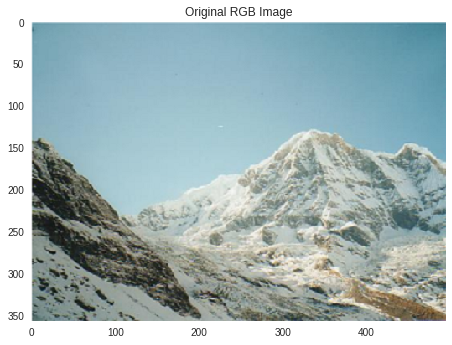

In [0]:
image_a = read_image('imagea.png')

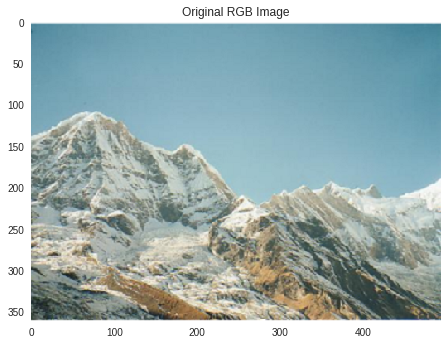

In [0]:
image_b = read_image('imageb.png')

# **Getting correspondences**

In [0]:
def detect_describe(image):
  orb = cv.ORB_create(nfeatures=1000)
  copy_img=image
  key_pts, descriptors = orb.detectAndCompute(copy_img, None) 
  return key_pts, descriptors

In [0]:
def draw_keypoints(image):
  image_keypoints = cv.drawKeypoints(copy_img,key_pts,copy_img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  plot_image(BGR2RGB(image_keypoints),"colored","Key Points")

In [0]:
def match(image_a,image_b):
  key_pts_a, descriptors_a=detect_describe(image_a)
  key_pts_b, descriptors_b=detect_describe(image_b)
#   copy_a=image_a
#   copy_b=image_b
#   draw_keypoints(copy_a,key_pts_a)
#   draw_keypoints(copy_b,key_pts_b)
  bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
  matches = bf.match(descriptors_a, descriptors_b)
  matches = sorted(matches, key = lambda x: x.distance,reverse=0)
  img_matches = cv.drawMatches(image_a, key_pts_a, image_b, key_pts_b, matches[:4], image_b, flags=2)
  plot_image(BGR2RGB(img_matches),"colored","Matching")
  # Initialize arrays
  kps_a = []
  kps_b = []
  matches=matches[:20]
  for match in matches:
    # Get the matching keypoints for each of the images
    img_a_idx = match.queryIdx
    img_b_idx = match.trainIdx
    # Get the coordinates
    (x1,y1) = key_pts_a[img_a_idx].pt
    (x2,y2) = key_pts_b[img_b_idx].pt
    # Append to each list
    kps_a.append((x1, y1))
    kps_b.append((x2, y2))   
  return kps_a , kps_b

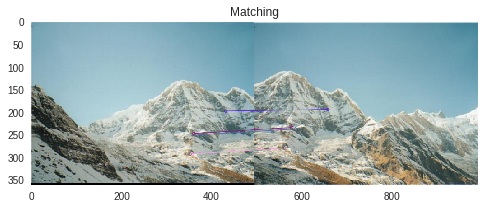

In [0]:
kps_a,kps_b = match(image_a,image_b)


# **Computing the homography parameters**

In [0]:
def get_coordinates(kps,index):
  point = kps[index]
  return point[0] , point[1]

In [0]:
def get_sub_a_matrix(x,y,x_,y_):
  matrix=np.zeros((2,8))
  matrix[0]=np.array([x, y,1,0,0,0, -x*x_, -y*x_])
  matrix[1]=np.array([0,0,0,x, y,1, -x*y_, -y*y_])
  return matrix

In [0]:
def get_homography_matrix(kps_a,kps_b):
  n=len(kps_a)
  #build b 
  b = np.zeros(((2*n),1))
  for i in range(n):
    b[2*i], b[2*i +1]=get_coordinates(kps_b,i)
  # build a
  a = np.zeros(((2*n),8))
  for i in range(n):
    x,y=get_coordinates(kps_a,i)
    x_,y_=get_coordinates(kps_b,i)
    sub_a_matrix=get_sub_a_matrix(x,y,x_,y_)
    a[2*i] = sub_a_matrix[0]
    a[2*i + 1] = sub_a_matrix[1]		
  # Solve equations to compute H
  H=np.linalg.lstsq(a, b)[0]
  H=np.append(H,1)
  H=np.reshape(H,(3,3))
  return H

In [0]:
H=get_homography_matrix(kps_a,kps_b)
H

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  app.launch_new_instance()


array([[ 1.46825710e+00, -2.93631802e-01, -3.47178199e+02],
       [ 3.95558424e-01,  1.27120007e+00, -1.48986666e+02],
       [ 1.05857504e-03, -2.53136435e-04,  1.00000000e+00]])

In [0]:
def get_coordinates_ransac(kps_rans,index):
  return kps_rans[index,0] , kps_rans[index,1] , kps_rans[index,2] , kps_rans[index,3]

In [0]:
def getlistsrandom(rand):
  kp_a = np.zeros((0,2))
  kp_b = np.zeros((0,2))
  for i in range(len(rand)):
      x1,y1,x_1,y_1=get_coordinates_ransac(rand,i)
      kp_a=np.vstack((kp_a,(x1,y1)))
      kp_b=np.vstack((kp_b,(x_1,y_1))) 
  return kp_a,kp_b

# **Calculate  geometric distance between estimated points and original points**

In [0]:
def get_error_ransac(correspondence, h):

    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

# **RANSAC**

In [0]:
def match(image_a,image_b):
  corres_List = []
  key_pts_a, descriptors_a=detect_describe(image_a)
  key_pts_b, descriptors_b=detect_describe(image_b)
#   copy_a=image_a
#   copy_b=image_b
#   draw_keypoints(copy_a,key_pts_a)
#   draw_keypoints(copy_b,key_pts_b)
  bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
  matches = bf.match(descriptors_a, descriptors_b)
  matches = sorted(matches, key = lambda x: x.distance)
  img_matches = cv.drawMatches(image_a, key_pts_a, image_b, key_pts_b, matches[:4], image_b, flags=2)
  plot_image(BGR2RGB(img_matches),"colored","Matching")
  num_of_req_matches=10
  # Initialize arrays
  kps_a = np.zeros((0,2))
  kps_b = np.zeros((0,2))
  matches=matches[:num_of_req_matches]
  for match in matches:
    # Get the matching keypoints for each of the images
    img_a_idx = match.queryIdx
    img_b_idx = match.trainIdx
    # Get the coordinates
    (x1,y1) = key_pts_a[img_a_idx].pt
    (x2,y2) = key_pts_b[img_b_idx].pt
    # Append to each list
    #############################################################
    corres_List.append([x1, y1, x2, y2]) 
    #############################################################
    kps_a=np.vstack((kps_a,(x1, y1)))
    kps_b=np.vstack((kps_b,(x2, y2))) 
    
  correspoints = np.matrix(corres_List)
 
  return kps_a , kps_b ,correspoints ,matches

# **Ransac function**

In [0]:
def ransac(corres, thresh):
    maxInliers = []
    finalH = None
    
    for i in range(100000):
      
        #find 4 random points to calculate a homography
        corres_random_1 = corres[random.randrange(0, len(corres))]
        corres_random_2 = corres[random.randrange(0, len(corres))]
        randompoints = np.vstack((corres_random_1, corres_random_2))
        corres_random_3 = corres[random.randrange(0, len(corres))]
        randompoints = np.vstack(( randompoints, corres_random_3))
        
        corres_random_4 = corres[random.randrange(0, len(corres))]
        randompoints = np.vstack((randompoints, corres_random_4))
        

        #call the homography function on those points
        
        kp_a,kp_b=getlistsrandom(randompoints)
        
        h = get_homography_matrix( kp_a,kp_b)
        
        
       # h=get_homography_matrix_Ransac(randomFour)
        inliers = []

        for i in range(len(corres)):
            d = get_error_ransac(corres[i], h)
            if d < 5:
                inliers.append(corres[i])
                print("inliers : ",len(inliers))
               
        print("-----------------------------------------------")
        if len(inliers) > len(maxInliers):
          
            maxInliers = inliers
           
            finalh= h
            
        print ("Corr size: ", len(corres), " NumInliers: ", len(inliers), "Max inliers: ", len(maxInliers))

        if len(maxInliers) > (len(corres)*thresh):
            break
        return finalh, maxInliers , kp_a,kp_b 

[[355.9680481  292.03201294]
 [367.20001221 249.6000061 ]
 [360.         246.24000549]
 [430.80001831 196.80000305]
 [358.56002808 288.        ]
 [345.60003662 264.3840332 ]
 [342.72000122 256.32000732]
 [341.27999878 292.32000732]
 [350.7840271  297.21603394]
 [370.80001831 248.40000916]]
[[ 69.12001038 278.20803833]
 [ 90.         236.40000916]
 [ 82.08000183 233.28001404]
 [162.         193.20001221]
 [ 72.         275.04000854]
 [ 63.93600464 248.83203125]
 [ 63.36000061 240.48001099]
 [ 50.40000153 279.36001587]
 [ 62.20800781 283.39202881]
 [ 93.6000061  235.20001221]]
hna:corrs  [[355.9680481  292.03201294  69.12001038 278.20803833]
 [367.20001221 249.6000061   90.         236.40000916]
 [360.         246.24000549  82.08000183 233.28001404]
 [430.80001831 196.80000305 162.         193.20001221]
 [358.56002808 288.          72.         275.04000854]
 [345.60003662 264.3840332   63.93600464 248.83203125]
 [342.72000122 256.32000732  63.36000061 240.48001099]
 [341.27999878 292.320

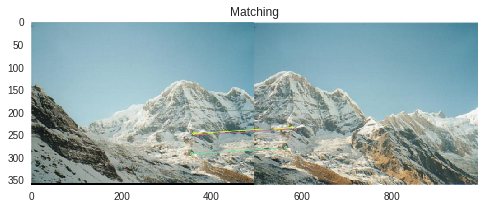

In [0]:
kps_a,kps_b,correspoints,matches = match(image_a,image_b)
print(kps_a)
print(kps_b)
print("hna:corrs ",correspoints)

In [0]:
finalh, inliers ,kp_a,kp_b = ransac(correspoints,5)
print("\n")
print ("Final homography: ")
print(finalh)
print ("Final inliers count: ", len(inliers))


inliers :  1
inliers :  2
inliers :  3
inliers :  4
inliers :  5
-----------------------------------------------
Corr size:  10  NumInliers:  5 Max inliers:  5


Final homography: 
[[ 5.84143862e-01 -6.33098180e-01 -2.04112458e-04]
 [ 2.44631281e-01  2.34419071e-01  4.33557509e-03]
 [ 5.51992668e-04 -2.30440409e-03  1.00000000e+00]]
Final inliers count:  5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  app.launch_new_instance()


Verify Homography matrix

In [0]:
def verify_H(px,py,H):
  a=np.ones((3,1))
  a[0,0]=px
  a[1,0]=py
  b=np.dot(H,a)
  b=b/b[2,0]
  print(b)

In [0]:
verify_H(kps_a[2,0],kps_a[2,1],finalh)

[[ 86.17002068]
 [230.95099749]
 [  1.        ]]


In [0]:
print("impl_ransac function : \n",finalh)
h,mask= cv.findHomography(kp_a, kp_b, cv.RANSAC,5)
print("\n")
print("built in function for ransac : \n",h)

impl_ransac function : 
 [[ 5.84143862e-01 -6.33098180e-01 -2.04112458e-04]
 [ 2.44631281e-01  2.34419071e-01  4.33557509e-03]
 [ 5.51992668e-04 -2.30440409e-03  1.00000000e+00]]


built in function for ransac : 
 [[ 3.85468733e-01  2.17197186e-01 -1.60801953e+02]
 [-3.77153898e-01  2.00374408e-01  1.80291522e+02]
 [-1.56751359e-03 -1.44329549e-04  1.00000000e+00]]


# **Warping**

In [0]:
def transform(point,H):
  result = np.dot(H, point)
  w=result[2]
  result[0] = result[0]/w
  result[1] = result[1]/w
  result[2] = 1
  return result		

In [0]:
def inv_transform(point,H):
  result = np.dot(np.linalg.inv(H), point)
  w=result[2]
  result[0] = result[0]/w
  result[1] = result[1]/w
  result[2] = 1
  return result

In [0]:
def wraped_image_size(image_a , H):
  height = image_a.shape[0]
  width = image_a.shape[1]
  
  boundaries = np.array([[0,0],[height-1, 0],[0, width-1],[height-1, width-1]])
  i_s =np.zeros(4,dtype=int)
  j_s =np.zeros(4,dtype=int)
  
  for k in range(0,4):
    i = boundaries[k][0]
    j = boundaries[k][1]
    mapped = transform(np.array([[j],[i],[1]]), H)
    j_s[k] = int(mapped[0][0])
    i_s[k] = int(mapped[1][0])
          
  min_mapped_i=np.min(i_s)
  min_mapped_j=np.min(j_s)
  max_mapped_i=np.max(i_s)
  max_mapped_j=np.max(j_s)
   
  new_height = (max_mapped_i-min_mapped_i+1)
  new_width = (max_mapped_j-min_mapped_j+1)
  
  height_shift =-min_mapped_i
  width_shift =-min_mapped_j
  
  return (new_height,new_width,height_shift,width_shift)

In [0]:
def wrap(image_a , H):
  height = image_a.shape[0]
  width = image_a.shape[1]

  (wraped_image_height,wraped_image_width,height_shift,width_shift)=wraped_image_size(image_a , H)
  wraped_image = np.zeros((wraped_image_height,wraped_image_width,3), dtype=np.uint8);
  
  for i in range(0,image_a.shape[0]):
    for j in range(0,image_a.shape[1]):
      mapped = transform(np.array([[j],[i],[1]]), H)
      mapped_j = int(mapped[0][0])
      mapped_i = int(mapped[1][0])
      wraped_image[mapped_i+height_shift][mapped_j+width_shift] = image_a[i][j]
      
  return (wraped_image,height_shift,width_shift)

In [0]:
def remove_holes(wraped_image,H,image_a,height_shift,width_shift):
  height = image_a.shape[0]
  width = image_a.shape[1]
  
  wraped_image_height=wraped_image.shape[0]
  wraped_image_width=wraped_image.shape[1]
  
  for i in range(0, wraped_image_height):
    for j in range(0, wraped_image_width):
      if int(wraped_image[i][j][0]) == 0 and int(wraped_image[i][j][1]) == 0 and int(wraped_image[i][j][2]) == 0:
        inv_mapped = inv_transform(np.array([[(j - width_shift)], [(i-height_shift)],[1]]),H)
        inv_mapped_j = inv_mapped[0][0]
        inv_mapped_i = inv_mapped[1][0]
        if inv_mapped_i <= height-1 and  inv_mapped_i >= 0 and inv_mapped_j <= width-1 and inv_mapped_j >= 0:
          index_i = int(inv_mapped_i);
          index_j = int(inv_mapped_j);
          a = inv_mapped_i - index_i;
          b = inv_mapped_j - index_j;
          wraped_image[i][j] = (1-a)*(1-b)*image_a[index_i][index_j]+ a*(1-b)*image_a[index_i+1][index_j]+ a*b*image_a[index_i+1][index_j+1]+ (1-a)*b*image_a[index_i][index_j+1]  
  return wraped_image

In [0]:
def create_mosaic(wraped_image,image_b,height_shift,width_shift):
  wraped_image_height=wraped_image.shape[0]
  wraped_image_width=wraped_image.shape[1]

  image_b_height = image_b.shape[0]
  image_b_width = image_b.shape[1]
  
  mosaic_height=0
  mosaic_width=0

  if wraped_image_height > image_b_height + height_shift :
    mosaic_height = wraped_image_height
  else:
    mosaic_height = image_b_height + height_shift

  if mosaic_width > image_b_width + width_shift:
    mosaic_width = mosaic_width
  else:
    mosaic_width = image_b_width + width_shift

  mosaic = np.zeros((mosaic_height, mosaic_width, 3), dtype=np.uint8)
  
  for i in range(0,image_b_height):
    for j in range(0, image_b_width):
      mosaic[i+height_shift][j+width_shift] = image_b[i][j]
  
  for i in range(0,wraped_image_height):
    for j in range(0, wraped_image_width):
      if not(int(wraped_image[i][j][0]) == 0 and int(wraped_image[i][j][0]) == 0 and int(wraped_image[i][j][2]) == 0):
        mosaic[i][j] = wraped_image[i][j]
        
  return mosaic     

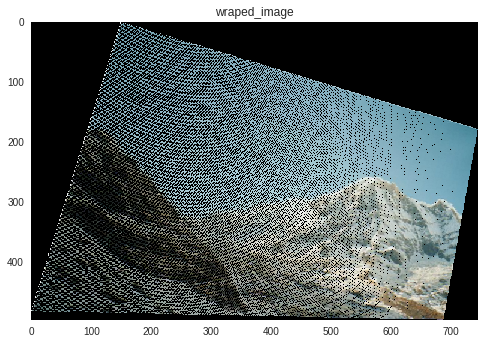

In [0]:
(wraped_image,height_shift,width_shift) = wrap(image_a,H)
plot_image(BGR2RGB(wraped_image),'colored','wraped_image')

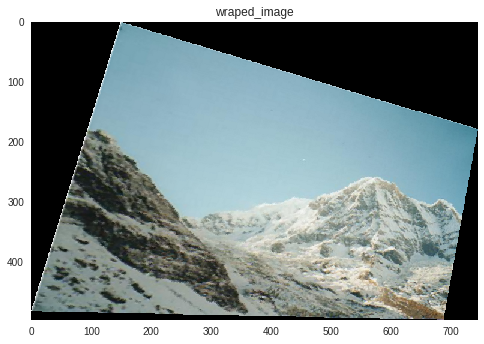

In [0]:
wraped_image=remove_holes(wraped_image,H,image_a,height_shift,width_shift)
plot_image(BGR2RGB(wraped_image),'colored','wraped_image')

# **Final Output**

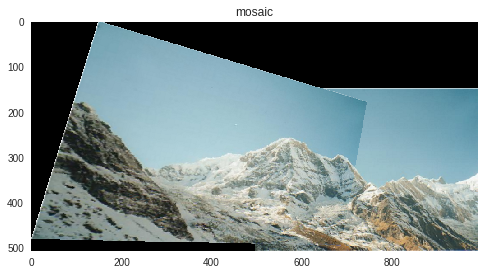

In [0]:
mosaic=create_mosaic(wraped_image,image_b,height_shift,width_shift)
plot_image(BGR2RGB(mosaic),'colored','mosaic')